In [435]:
# set this notebook one level above State_denoise_RNN. Then we can just keep 
# track of it with git and exchange it between the server and local
import os
path = os.getcwd()
if "State" not in path:
    path = os.getcwd() + '/State_Denoised_RNN'
print(path)
os.chdir(path)

/Users/denis/Dropbox/school/research/State_Denoised_RNN


In [400]:
from __future__ import print_function, division
import itertools
import tensorflow as tf
import numpy as np
import sys
import argparse
import fsm
%load_ext autoreload
%autoreload 2

import sys
def progress_print(i, total, spacing=20):
    if i % spacing == 0:
        string_params_tuple = (i, total)
        sys.stdout.write("\r%i / %i" % string_params_tuple)
        sys.stdout.flush()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
import pickle
import datetime

class MutInfSaver():
    def __init__(self):
        self.losses_task = []
        self.h_inits = [] # h_init, all attractor iterations, h_next
        self.h_attractors = []
        self.h_finals = []
        
    def update(self, loss_task, h_init, h_attractor, h_final):
        self.losses_task.append(loss_task)
        self.h_inits.append(h_init)
        self.h_attractors.append(h_attractor)
        self.h_finals.append(h_final)

    def split_ids(self):
        "splits the array into separate sessions and normalizes each session by its maximum id (epoch number)"
        a = self.losses_task
        ids = []
        for i in range(len(a)):
            if a == 0.0:
                ids.append(i)
        return ids    
    
class WeightSaver():
    def __init__(self):
        self.epoch_number_history = []
        self.losses_att = []
        self.losses_task = []
        self.weights_history = []
        self.acc_history = []
        self.h_history = []
        self.bias_history = []
        self.scaling_const_history = []
        self.bias_lambda_history = []
        
        self.directory = "experiments/weight_pickles/"
    
    def update(self, epoch_number, loss_att, loss_task, W_att, b_att, scaling_const, acc, h_seq):
        self.epoch_number_history.append(epoch_number)
        
        self.losses_att.append(loss_att)
        self.losses_task.append(loss_task)
        
        self.weights_history.append(W_att)
        self.bias_history.append(b_att)
        self.scaling_const_history.append(scaling_const)
        
        self.acc_history.append(acc)
        self.h_history.append(h_seq)
        
        
    def update_conservative(self, epoch_number, loss_att, loss_task, acc):
        self.epoch_number_history.append(epoch_number)
        self.losses_att.append(loss_att)
        self.losses_task.append(loss_task)
        self.acc_history.append(acc)

    def get_hashmap_format(self):
        hashmap = {
            "losses_att"        :   self.losses_att,
            "losses_task"       :   self.losses_task, 
            "weights_history"   :   self.weights_history, 
            "acc_history"       :   self.acc_history, 
            "h_history"         :   self.h_history, 
            "bias_history"      :   self.bias_history,
            "bias_lambda"       :   self.bias_lambda_history
        }
        
        return hashmap
    
    def pickle_history(self, ops, comment):
        element_map = self.get_hashmap_format()
        title = self.directory + "({})[Model<{}>(attractor<{}>, noise<{}>), Problem<{}>]__{}.pickle".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['attractor_noise_level'],
                                                           ops['problem_type'],
                                                           comment)
        with open(title, 'wb') as handle:
            pickle.dump(element_map, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Saved successfully")
        
    def unpickle_history(self, title, rewrite=False):
        title = self.directory + title
        with open(title, 'rb') as handle:
            element_map = pickle.load(handle)
        
        if rewrite:
            self.losses_att = element_map["losses_att"]
            self.losses_task = element_map["losses_task"]
            self.weights_history = element_map["weights_history"]
            self.acc_history = element_map["acc_history"]
            self.h_history = element_map["h_history"]
            self.bias_history = element_map["bias_history"]
            
        return element_map
        
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Layer Normalization [https://theneuralperspective.com/2016/10/27/gradient-topics/]
def ln(inputs, epsilon = 1e-5, scope = None):
 
    """ Computer LN given an input tensor. We get in an input of shape
    [N X D] and with LN we compute the mean and var for each individual
    training point across all it's hidden dimensions rather than across
    the training batch as we do in BN. This gives us a mean and var of shape
    [N X 1].
    """
    mean, var = tf.nn.moments(inputs, [1], keep_dims=True)
    with tf.variable_scope(scope + 'LN'):
        scale = tf.get_variable('alpha',
                                shape=[inputs.get_shape()[1]],
                                initializer=tf.constant_initializer(1))
        shift = tf.get_variable('beta',
                                shape=[inputs.get_shape()[1]],
                                initializer=tf.constant_initializer(0))
    LN = scale * (inputs - mean) / tf.sqrt(var + epsilon) + shift
 
    return LN

In [427]:
#!/usr/local/bin/python

# This version of the code trains the attractor connections with a separate
# objective function than the objective function used to train all other weights
# in the network (on the prediction task).

from __future__ import print_function
import itertools
import tensorflow as tf
import numpy as np
import sys
import argparse
import fsm

ops = {
        'model_type': "GRU", # OPTIONS: vanilla, LSTM_raw, LSTM_tensorflow, LSTM_attractor
        'hid': 5,
        'in': None, #TBD
        'out': 1,
#         'batch_size':n_examples, #since the sequences are 1-dimensional it's easier to just run them all at once
        'n_attractor_iterations': 0,
        'attractor_dynamics': "projection3", # OPTIONS:  "" (for no attractor dynamics),
                                    #           "direct" (simple attractor weights applied to hidden states directly, trained with noise addition)
                                    #           "projection" (project the hidden state into a separate space via weights, do attraction, project back)
                                    #           "helper_hidden" (hidden-hidden neurons) - IMPORTANT: don't forget to add h_hid number
        'h_hid': 5, # helper hidden for "helper hidden" "attractory_dynamics" mode
        'attractor_noise_level': 0.2,
        'attractor_noise_type': "bernoilli", # OPTIONS: "gaussian", "dropout", "random_drop"
    
        'attractor_regularization': "", # OPTIONS: "l2", ""
        'attractor_regularization_lambda': 0.05,
    
        'record_mutual_information': True,
       'problem_type': "parity" # OPTIONS: parity, majority, reber, kazakov
       }



# !!!!!!!!!!!!!!!!!!!!!!            
SEQ_LEN = 12 # number of bits in input sequence   
N_HIDDEN = ops['hid']       
                      # number of hidden units
N_H_HIDDEN = ops['h_hid']
# !!!!!!!!!!!!!!!!!!!!!!            

ARCH = ops['model_type']      # hidden layer type: 'GRU' or 'tanh'
NOISE_LEVEL = ops['attractor_noise_level']
                      # noise in training attractor net 
                      # if >=0, Gaussian with std dev NOISE_LEVEL 
                      # if < 0, Bernoulli dropout proportion -NOISE_LEVEL 
            
# !!!!!!!!!!!!!!!!!!!!!! 
INPUT_NOISE_LEVEL = 0.1
ATTRACTOR_TYPE = ops['attractor_dynamics']
N_ATTRACTOR_STEPS = ops['n_attractor_iterations']
                      # number of time steps in attractor dynamics
                      # if = 0, then no attractor net
# !!!!!!!!!!!!!!!!!!!!!!            


        
ATTR_WEIGHT_CONSTRAINTS = True
                      # True: make attractor weights symmetric and have zero diag
                      # False: unconstrained
TRAIN_ATTR_WEIGHTS_ON_PREDICTION = False
                      # True: train attractor weights on attractor net _and_ prediction
REPORT_BEST_TRAIN_PERFORMANCE = True
                      # True: save the train/test perf on the epoch for which train perf was best
LOSS_SWITCH_FREQ = 1
                      # how often (in epochs) to switch between attractor 
                      # and prediction loss

TASK = ops['problem_type']      # task (parity, majority, reber, kazakov)
if (TASK=='parity'):
    N_INPUT = 1           # number of input units
    N_CLASSES = 1         # number of output units
    N_TRAIN = 1000 # train on all seqs
    N_TEST = 1000#pow(2,SEQ_LEN)
    solved_problem_count = 0

elif (TASK=='majority'):
    N_INPUT = 1           # number of input units
    N_CLASSES = 1         # number of output units
    N_TRAIN = 64 
    N_TEST = 4096-64
elif (TASK=='reber'):
    N_INPUT = 7 # B E P S T V X
    N_CLASSES = 1
    N_TRAIN = 200
    N_TEST = 2000
elif (TASK=='kazakov'):
    N_INPUT = 5
    N_CLASSES = 1
    N_TRAIN = 400
    N_TEST = 2000
else:
    print('Invalid task: ',TASK)
    quit()


# Training Parameters

TRAINING_EPOCHS = 5000
N_REPLICATIONS = 30
BATCH_SIZE = N_TRAIN
DISPLAY_EPOCH = 9
LRATE_PREDICTION = 0.008
LRATE_ATTRACTOR = 0.008


# NOTEBOOK CODE

WS = WeightSaver()
MIS = MutInfSaver()
tf.reset_default_graph()

# the tf seed needs to be within the context of the graph. 
np.random.seed(100)
tf.set_random_seed(100)


















################ mozer_get_variable #####################################################

def mozer_get_variable(vname, mat_dim):
    if (len(mat_dim) == 1): # bias
        val = 0.1 * tf.random_normal(mat_dim)
        var = tf.get_variable(vname, initializer=val)

    else:
        #var = tf.get_variable(vname, shape=mat_dim,
        #                    initializer=tf.contrib.layers.xavier_initializer())

        #val = tf.random_normal(mat_dim)
        #var = tf.get_variable(vname, initializer=val)

        val = tf.random_normal(mat_dim)
        val = 2 * val / tf.reduce_sum(tf.abs(val),axis=0, keep_dims=True)
        var = tf.get_variable(vname, initializer=val)
    return var


################ GLOBAL VARIABLES #######################################################

# prediction input
X = tf.placeholder("float", [None, SEQ_LEN, N_INPUT])
# prediction output
Y = tf.placeholder("float", [None, N_CLASSES])
# attr net target
attractor_tgt_net = tf.placeholder("float", [None, N_HIDDEN])

# attr net weights
# NOTE: i tried setting attractor_W = attractor_b = 0 and attractor_scale=1.0
# which is the default "no attractor" model, but that doesn't learn as well as
# randomizing initial weights
# def xavier_init(shape, name):
#     return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

with tf.variable_scope("ATTRACTOR_WEIGHTS"):
    attr_net = {}
    if ATTRACTOR_TYPE == 'projection2' or ATTRACTOR_TYPE == "projection3": # attractor net 2
        attr_net['W_in'] = tf.get_variable("attractor_W_in", initializer=tf.eye(N_HIDDEN,num_columns=N_H_HIDDEN) + 
                                    .01*tf.random_normal([N_HIDDEN,N_H_HIDDEN]))
        attr_net['W_out'] = tf.get_variable("attractor_Wout", initializer=tf.eye(N_H_HIDDEN,num_columns=N_HIDDEN) + 
                                    .01*tf.random_normal([N_H_HIDDEN,N_HIDDEN]))
        attr_net['b_out'] = mozer_get_variable("attractor_b_out", [N_HIDDEN])
        attr_net['W'] = tf.get_variable("attractor_W", initializer=.01 * tf.random_normal([N_H_HIDDEN, N_H_HIDDEN]))
        attr_net['b'] = tf.get_variable("attractor_b", initializer=.01 * tf.random_normal([N_H_HIDDEN]))
    else:
        attr_net = {
            'W': tf.get_variable("attractor_W", initializer=.01 * tf.random_normal([N_HIDDEN, N_HIDDEN])),
            'b': tf.get_variable("attractor_b", initializer=.01 * tf.random_normal([N_HIDDEN]))
        }
    attr_net['scale'] = tf.get_variable("attractor_scale", initializer=.01 * tf.ones([1]))

if ATTR_WEIGHT_CONSTRAINTS: # symmetric + nonnegative diagonal weight matrix
    Wdiag = tf.matrix_band_part(attr_net['W'],0,0) # diagonal
    Wlowdiag = tf.matrix_band_part(attr_net['W'], -1, 0) - Wdiag # lower diagonal
    # the normalization will happen here automatically since we defined it as a TF op
    attr_net['Wconstr'] = Wlowdiag + tf.transpose(Wlowdiag) + tf.abs(Wdiag)
    #attr_net['Wconstr'] = .5 * (attr_net['W'] + tf.transpose(attr_net['W'])) * \
    #                      (1.0-tf.eye(N_HIDDEN)) + tf.abs(tf.matrix_band_part(attr_net['W'],0,0))

else:
    attr_net['Wconstr'] = attr_net['W'] 

################ generate_examples ######################################################

def generate_examples():

    if (TASK == 'parity'):
        X_train, Y_train = generate_parity_majority_sequences(SEQ_LEN, N_TRAIN)
        X_test, Y_test = generate_parity_majority_sequences(SEQ_LEN, N_TEST)
        if (INPUT_NOISE_LEVEL > 0.):
           X_test, Y_test = add_input_noise(INPUT_NOISE_LEVEL,X_test,Y_test,2)
    # for majority, split all sequences into training and test sets
    elif (TASK == 'majority'):
        X_train, Y_train = generate_parity_majority_sequences(SEQ_LEN, N_TRAIN+N_TEST)
        pix = np.random.permutation(N_TRAIN+N_TEST)
        X_train = X_train[pix[:N_TRAIN],:]
        Y_train = Y_train[pix[:N_TRAIN],:]
        X_test = X_train[pix[N_TRAIN:],:]
        Y_test = Y_train[pix[N_TRAIN:],:]
        if (INPUT_NOISE_LEVEL > 0.):
           X_test, Y_test = add_input_noise(INPUT_NOISE_LEVEL,X_test,Y_test,1)
    elif (TASK == 'reber'):
        _, Y_train, X_train, _ = fsm.generate_grammar_dataset(1, SEQ_LEN, N_TRAIN)
        _, Y_test, X_test, _ = fsm.generate_grammar_dataset(1, SEQ_LEN, N_TEST)
    elif (TASK == 'kazakov'):
        _, Y_train, X_train, _ = fsm.generate_grammar_dataset(2, SEQ_LEN, N_TRAIN)
        _, Y_test, X_test, _ = fsm.generate_grammar_dataset(2, SEQ_LEN, N_TEST)

    return [X_train, Y_train, X_test, Y_test]

################ add_input_noise ########################################################
# incorporate input noise into the test patterns

def add_input_noise(noise_level, X, Y, n_repeat):
# X: # examples X # sequence elements X #inputs
    X = np.repeat(X, n_repeat, axis=0)
    Y = np.repeat(Y, n_repeat, axis=0)
    X = X + (np.random.random(X.shape)*2.0-1.0) * noise_level
    return X,Y

################ generate_parity_majority_sequences #####################################

def generate_parity_majority_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    parity = lambda x: 1 if (x % 2 == 1) else 0
    majority = lambda x: 1 if x > N/2 else 0
    if (count >= 2**N):
        sequences = np.asarray([seq for seq in itertools.product([0,1],repeat=N)])
    else:
        sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # parity each sequence, expand dimensions by 1 to match sequences shape
    if (TASK == 'parity'):
        y = np.expand_dims(np.array([parity(x) for x in counts]), axis=1)
    else: # majority
        y = np.expand_dims(np.array([majority(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    return np.expand_dims(sequences, axis=2), y

################ get_batches ############################################################

def get_batches(num, data, labels):
    '''
    Return a total of `num` random samples and labels.
    '''
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    batches = []
    while len(idx) > 0:
       cur_idx = idx[:min(num, len(idx))]

       data_shuffle = [data[i] for i in cur_idx]
       labels_shuffle = [labels[i] for i in cur_idx]
       batches.append((np.asarray(data_shuffle), np.asarray(labels_shuffle)))
       idx = idx[num:]
    return batches

############### RUN_ATTRACTOR_NET #################################################

def run_attractor_net(input_bias):
    # input_bias - nonsquashed hidden state
    a_clean_collection = [] # for mutual inf estimation
    
    if (N_ATTRACTOR_STEPS > 0):
        if ATTRACTOR_TYPE == 'projection2':
            # task -> attractor space
            input_bias = tf.matmul(input_bias, attr_net['W_in']) + attr_net['b']

            a_clean = tf.zeros(tf.shape(input_bias))
            for i in range(N_ATTRACTOR_STEPS):
                # my version:
#                 a_clean = tf.tanh(tf.matmul(a_clean, attr_net['Wconstr']) \
#                           +  input_bias #attr_net['scale'] *
                  a_clean = tf.matmul(tf.tanh(a_clean), attr_net['Wconstr']) \
                          + input_bias 


            # attractor space -> task
            a_clean = tf.tanh(tf.matmul(a_clean, attr_net['W_out']) + attr_net['b_out'])
        elif ATTRACTOR_TYPE == 'projection3':
            # task -> attractor space
            h_bias = tf.matmul(tf.tanh(input_bias), attr_net['W_in']) + attr_net['b']

            a_clean = tf.zeros(tf.shape(h_bias))
            for i in range(N_ATTRACTOR_STEPS):
                a_clean = tf.tanh(tf.matmul(a_clean, attr_net['Wconstr']) + h_bias)
                a_clean_collection.append(a_clean)

            # attractor space -> tasky
            a_clean = tf.tanh(tf.matmul(a_clean, attr_net['W_out']) + attr_net['b_out'] + input_bias)
        else:
            a_clean = tf.zeros(tf.shape(input_bias))
            for i in range(N_ATTRACTOR_STEPS):
                a_clean = tf.matmul(tf.tanh(a_clean), attr_net['Wconstr']) \
                                            +  attr_net['scale'] *  input_bias + attr_net['b']
                a_clean_collection.append(a_clean)
#                 a_clean = tf.tanh(tf.matmul(a_clean, attr_net['Wconstr']) \
#                                   +  attr_net['scale'] * input_bias + attr_net['b'])

            a_clean = tf.tanh(a_clean)
    else:
        a_clean = tf.tanh(input_bias)
    return a_clean, a_clean_collection


############### ATTRACTOR NET LOSS FUNCTION #####################################

def attractor_net_loss_function(attractor_tgt_net, params):
    # attractor_tgt_net has dimensions #examples X #hidden
    #                   where the target value is tanh(attractor_tgt_net)

    # clean-up for attractor net training
    if (NOISE_LEVEL >= 0.0): # Gaussian mean-zero noise
        input_bias = attractor_tgt_net + NOISE_LEVEL \
                                 * tf.random_normal(tf.shape(attractor_tgt_net))
    else: # Bernoulli dropout
        input_bias = attractor_tgt_net * \
                tf.cast((tf.random_uniform(tf.shape(attractor_tgt_net)) \
                                                  >= -NOISE_LEVEL),tf.float32)

    a_cleaned, _ = run_attractor_net(input_bias)

    # loss is % reduction in noise level
    attr_tgt = tf.tanh(attractor_tgt_net)
    attr_loss = tf.reduce_mean(tf.pow(attr_tgt - a_cleaned,2)) /\
                tf.reduce_mean(tf.pow(attr_tgt - tf.tanh(input_bias),2))

    if ops['attractor_regularization'] == 'l2':
        print("L2 Regularization")
        attr_loss += ops['attractor_regularization_lambda']*tf.norm(attr_net['W'], ord=2)
        
    return attr_loss, input_bias


############### GRU ###############################################################

def GRU_params_init():
    with tf.variable_scope("TASK_WEIGHTS"):
        W = {'out': mozer_get_variable("W_out", [N_HIDDEN, N_CLASSES]),
             'in_stack': mozer_get_variable("W_in_stack", [N_INPUT, 3*N_HIDDEN]),
             'rec_stack': mozer_get_variable("W_rec_stack", [N_HIDDEN,3*N_HIDDEN]),
            }

        b = {'out': mozer_get_variable("b_out", [N_CLASSES]),
             'stack': mozer_get_variable("b_stack", [3 * N_HIDDEN]),
            }

    params = {
        'W': W,
        'b': b
    }
    return params

def GRU(X, params):
    with tf.variable_scope("GRU"):
        W = params['W']
        b = params['b']

        block_size = [-1, N_HIDDEN]

        def _step(accumulated_vars, input_vars):
            h_prev, _, _ = accumulated_vars
            x = input_vars

            preact = tf.matmul(x, W['in_stack'][:,:N_HIDDEN*2]) + \
                     tf.matmul(h_prev, W['rec_stack'][:,:N_HIDDEN*2]) + \
                     b['stack'][:N_HIDDEN*2]
            z = tf.sigmoid(tf.slice(preact, [0, 0 * N_HIDDEN], block_size))
            r = tf.sigmoid(tf.slice(preact, [0, 1 * N_HIDDEN], block_size))
            # new potential candidate for memory vector
            c_cand = tf.tanh( tf.matmul(x, W['in_stack'][:,N_HIDDEN*2:]) + \
                              tf.matmul(h_prev * r, W['rec_stack'][:,N_HIDDEN*2:]) + \
                              b['stack'][N_HIDDEN*2:])
            h = z * h_prev + (1.0 - z) * c_cand

            # insert attractor net
            h_net = tf.atanh(tf.minimum(.99999, tf.maximum(-.99999, h))) 
            h_cleaned, h_attractor_collection = run_attractor_net(h_net)
            return [h_cleaned, h_net, h_attractor_collection]

        # X:                       (batch_size, SEQ_LEN, N_HIDDEN) 
        # expected shape for scan: (SEQ_LEN, batch_size, N_HIDDEN) 
        batch_size = tf.shape(X)[0]
        [h_clean_seq, h_net_seq, h_attractor_collection] = tf.scan(_step, 
                  elems=tf.transpose(X, [1, 0, 2]),
                  initializer=[tf.zeros([batch_size, N_HIDDEN], tf.float32),  # h_clean
                               tf.zeros([batch_size, N_HIDDEN], tf.float32),  # h_net
                                [tf.zeros([batch_size, ops['h_hid']], tf.float32) for i in range(ops['n_attractor_iterations'])] ],   
                                  name='GRU/scan')

        out = tf.nn.sigmoid(tf.matmul(h_clean_seq[-1], W['out']) + b['out'])
        return [out, h_net_seq, h_attractor_collection, h_clean_seq]

######### END GRU #################################################################


######### BEGIN TANH RNN ########################################################

def RNN_tanh_params_init():
    with tf.variable_scope("TASK_WEIGHTS"):
        W = {'in' : mozer_get_variable("W_in",[N_INPUT, N_HIDDEN]),
             'rec' : mozer_get_variable("W_rec", [N_HIDDEN, N_HIDDEN]),
             'out': mozer_get_variable("W_out", [N_HIDDEN, N_CLASSES]),
            }
        b = {'rec': mozer_get_variable("b_rec", [N_HIDDEN]),
             'out': mozer_get_variable("b_out", [N_CLASSES]),
            }

    params = {
        'W': W,
        'b': b
    }
    return params


def RNN_tanh(X, params):
    W = params['W']
    b = params['b']
    
    def _step(accumulated_vars, input_vars):
        h_prev, _, = accumulated_vars
        x = input_vars

        # update the hidden state but don't apply the squashing function
        h_net = tf.matmul(h_prev, W['rec']) + tf.matmul(x, W['in']) + b['rec']

        # insert attractor net
        h_cleaned = run_attractor_net(h_net)

        return [h_cleaned, h_net]

    # X:                       (batch_size, SEQ_LEN, N_INPUT) 
    # expected shape for scan: (SEQ_LEN, batch_size, N_INPUT) 
    batch_size = tf.shape(X)[0]
    [h_clean_seq, h_net_seq] = tf.scan(_step,
                  elems=tf.transpose(X, [1, 0, 2]),
                  initializer=[tf.zeros([batch_size, N_HIDDEN], tf.float32),  # h_clean
                               tf.zeros([batch_size, N_HIDDEN], tf.float32)], # h_net
                  name='RNN/scan')

    out = tf.nn.sigmoid(tf.matmul(h_clean_seq[-1], W['out']) + b['out'])

    return [out, h_net_seq]
    # out:                     (batch_size)
    # h_net_seq                (SEQ_LEN, batch_size, N_HIDDEN)

######### END TANH RNN ##########################################################


######### MAIN CODE #############################################################
print(ops)
# Define architecture graph
if (ARCH == 'tanh'):
    params = RNN_tanh_params_init()
    [Y_, h_net_seq] = RNN_tanh(X, params)
elif (ARCH == 'GRU'):
    params = GRU_params_init()
    [Y_, h_net_seq, h_attractor_collection, h_clean_seq] = GRU(X, params)
else:
    print("ERROR: undefined architecture")
    exit()

# Define loss graphs
pred_loss_op = tf.reduce_mean(tf.pow(Y_ - Y, 2) / .25)
attr_loss_op, input_bias = \
           attractor_net_loss_function(attractor_tgt_net, params)

# separate out parameters to be optimized
prediction_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TASK_WEIGHTS")
attr_net_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "ATTRACTOR_WEIGHTS")
# attr_net_parameters.remove(attr_net['Wconstr']) # not a real parameter

if (TRAIN_ATTR_WEIGHTS_ON_PREDICTION):
    prediction_parameters += attr_net_parameters

# Define optimizer for prediction task
optimizer_pred = tf.train.AdamOptimizer(learning_rate=LRATE_PREDICTION)
pred_train_op = optimizer_pred.minimize(pred_loss_op, var_list=prediction_parameters)
# Define optimizer for attractor net task
if (N_ATTRACTOR_STEPS > 0):
    optimizer_attr = tf.train.AdamOptimizer(learning_rate=LRATE_ATTRACTOR)
    attr_train_op = optimizer_attr.minimize(attr_loss_op, var_list=attr_net_parameters)
# Evaluate model accuracy
correct_pred = tf.equal(tf.round(Y_), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    saved_train_acc = []
    saved_test_acc = []
    saved_epoch = []
    saved_att_loss = []
    # Start training
    for replication in range(N_REPLICATIONS):
        print("********** replication ", replication," **********")
        sess.run(init) # Run the initializer
        if (0):
           writer = tf.summary.FileWriter("./tf.log",sess.graph)
           writer.close()

        [X_train, Y_train, X_test, Y_test] = generate_examples()

        train_prediction_loss = True
        best_train_acc = -1000.
        best_test_acc = 0
        best_att_loss = 0
        for epoch in range(1, TRAINING_EPOCHS + 2):
            if (epoch-1) % DISPLAY_EPOCH == 0:
                ploss, train_acc, hid_vals = sess.run([pred_loss_op, accuracy, h_net_seq],
                                             feed_dict={X: X_train, Y: Y_train})
                aloss = sess.run(attr_loss_op,feed_dict={attractor_tgt_net: \
                                                           hid_vals.reshape(-1,N_HIDDEN)})
                if ops['record_mutual_information']:
                    h_attractor_val, h_clean_val = sess.run([h_attractor_collection, h_clean_seq],
                                                                   feed_dict={X: X_train, Y: Y_train})
                    MIS.update(ploss, np.tanh(hid_vals), h_attractor_val, h_clean_val)
                #print(hid_vals.reshape(-1,N_HIDDEN)[:,:])
                test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: Y_test})
                print("epoch " + str(epoch-1) + ", Loss Pred " + \
                          "{:.4f}".format(ploss) + ", Loss Att " + \
                          "{:.4f}".format(aloss) + ", Train Acc= " + \
                          "{:.3f}".format(train_acc) + ", Test Acc= " + \
                          "{:.3f}".format(test_acc))
                
                WS.update_conservative(
                                epoch_number = epoch,
                                loss_att = aloss, 
                                loss_task = ploss, 
#                                 W_att=sess.run(attr_net['W']), 
#                                 b_att = sess.run(attr_net['W']), 
#                                 scaling_const = None,
                                acc = test_acc,
#                                 h_seq = None
                                )
                print(np.linalg.norm(sess.run(attr_net['W'])))
                
                if (train_acc > best_train_acc):
                    best_train_acc = train_acc
                    best_test_acc = test_acc
                    best_att_loss = aloss
                if (train_acc == 1.0):
                    break
            if epoch > 1 and LOSS_SWITCH_FREQ > 0 \
                         and (epoch-1) % LOSS_SWITCH_FREQ == 0:
                train_prediction_loss = not train_prediction_loss
            batches = get_batches(BATCH_SIZE, X_train, Y_train)
            for (batch_x, batch_y) in batches:
                if (LOSS_SWITCH_FREQ == 0 or train_prediction_loss):
                    # Optimize all parameters except for attractor weights
                    _, hid_vals = sess.run([pred_train_op, h_net_seq], 
                                           feed_dict={X: batch_x, Y: batch_y})
                if (LOSS_SWITCH_FREQ == 0 or not train_prediction_loss):
                    if (N_ATTRACTOR_STEPS > 0):
                        # Optimize attractor weights
                        hid_vals = sess.run(h_net_seq, feed_dict={X: batch_x, Y: batch_y})
                        sess.run(attr_train_op, feed_dict={attractor_tgt_net: 
                                                       hid_vals.reshape(-1,N_HIDDEN)})

        print("Optimization Finished!")
        
        if ops['record_mutual_information']:
            MIS.update(0.0, [], [], [])
        if (REPORT_BEST_TRAIN_PERFORMANCE):
            saved_train_acc.append(best_train_acc)
            saved_test_acc.append(best_test_acc)
            saved_att_loss.append(best_att_loss)
        else:
            saved_train_acc.append(train_acc)
            saved_test_acc.append(test_acc)
            saved_att_loss.append(aloss)
        if (train_acc == 1.0):
            saved_epoch.append(epoch)

        # print weights
        #for p in attr_net.values():
        #    print (p.name, ' ', p.eval())
    print('********************************************************************')
    print(args)
    print('********************************************************************')
    print('mean train accuracy', np.mean(saved_train_acc))
    print('indiv runs ',saved_train_acc)
    print('mean epoch', np.mean(saved_epoch))
    print('indiv epochs ',saved_epoch)
    print('mean test accuracy', np.mean(saved_test_acc))
    print('indiv runs ',saved_test_acc)



{'attractor_regularization_lambda': 0.05, 'attractor_dynamics': 'projection3', 'hid': 5, 'in': None, 'h_hid': 5, 'problem_type': 'parity', 'out': 1, 'record_mutual_information': True, 'attractor_regularization': '', 'attractor_noise_level': 0.2, 'n_attractor_iterations': 0, 'model_type': 'GRU', 'attractor_noise_type': 'bernoilli'}
********** replication  0  **********
epoch 0, Loss Pred 0.9932, Loss Att 1.0000, Train Acc= 0.530, Test Acc= 0.491
0.0467573
epoch 9, Loss Pred 0.9903, Loss Att 1.0000, Train Acc= 0.541, Test Acc= 0.487
0.0467573
epoch 18, Loss Pred 0.9892, Loss Att 1.0000, Train Acc= 0.553, Test Acc= 0.488
0.0467573
epoch 27, Loss Pred 0.9881, Loss Att 1.0000, Train Acc= 0.544, Test Acc= 0.484
0.0467573
epoch 36, Loss Pred 0.9876, Loss Att 1.0000, Train Acc= 0.536, Test Acc= 0.481
0.0467573
epoch 45, Loss Pred 0.9870, Loss Att 1.0000, Train Acc= 0.534, Test Acc= 0.484
0.0467573
epoch 54, Loss Pred 0.9866, Loss Att 1.0000, Train Acc= 0.548, Test Acc= 0.489
0.0467573
epoch 63

KeyboardInterrupt: 

# Mutual information calculation

In [428]:
from sklearn.metrics.cluster import mutual_info_score
import scipy as sc

def get_mut_inf_for_vecs(A, B, n_bins=10):
    """
    return the average mut_inf between all neuron pairs of 2 vectors given
    """
    m = A.shape[1]
    n = B.shape[1]
    bins = np.array([-1.0 + 2.0*i/n_bins for i in range(n_bins+1)])
    A_digitized = np.digitize(A, bins)
    B_digitized = np.digitize(B, bins)
    
    total_mut_inf = 0.0
    for i in range(m):
        for j in range(n):
#             print(A[i], A_digitized[i])
#             print(mutual_info_score(A_digitized[i], B_digitized[j]))
            total_mut_inf += mutual_info_score(A_digitized[:,i], B_digitized[:,j])
    return total_mut_inf/(m*n)    

def flat_mutual_inf(h_init, h_atts, h_final):
    """
    returns an array of of mutual information values between initial hidden vector
    and all consecutive attractor state vectors
    - each "distribution" of a neuron is an observation for one sequence
    """
    if h_init == []:
        return [] #for matching a space between new runs
    # flatten over the sequence & batches
    H_target = h_init.reshape(-1, ops['hid'])
    Hs = [H_target]
    for h_att in h_atts:
        Hs.append(h_att.reshape(-1, ops['h_hid']))
    Hs.append(h_final.reshape(-1, ops['hid']))

    mut_infs = []
    for H in Hs:
        mut_inf = get_mut_inf_for_vecs(H_target, H)
        mut_infs.append(mut_inf)
    return mut_infs

def compute_avg_entropy_vec(h_final, n_bins=10):
    if h_final == []:
        return 0.0 #for matching a space between new runs
    
    h_flat = h_final.reshape(-1, ops['hid'])
    
    # put values into bins
    bins = np.array([-1.0 + 2.0*i/n_bins for i in range(n_bins+1)])
    h_digitized = np.digitize(h_flat, bins)
    # compute probability for each bin
    neurons_entropy = []
    for neuron_i in range(h_digitized.shape[1]):
        neuron_distn = h_digitized[:,neuron_i]
#         pdf = np.bincount(neuron_distn)/len(neuron_distn)
        _, pdf = np.unique(neuron_distn, return_counts=True) # returns sorted by unique value
        neurons_entropy.append(sc.stats.entropy(pdf))
    return np.average(neurons_entropy)


def process_each_training_example(MIS, mode, skip=1):
    # get_mut_inf_for_vecs(MIS.h_inits[57].reshape(-1, ops['hid']), MIS.h_inits[57].reshape(-1, ops['hid']))
    collect = []
    for id in range(0, len(MIS.losses_task), skip):
        progress_print(id, len(MIS.losses_task), 20)
        if mode == 'over_attractor_iterations':
            mut_infs = flat_mutual_inf(MIS.h_inits[id], MIS.h_attractors[id], MIS.h_finals[id])
            collect.append(mut_infs)
        elif mode == 'scatter_perf_entropy':
            entropy_avg = compute_avg_entropy_vec(MIS.h_finals[id])
            collect.append(entropy_avg)
    return collect

    
entropy_collection1 = process_each_training_example(MIS, 'scatter_perf_entropy')

60 / 2036

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:44: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


2020 / 2036

In [408]:
x = np.array([1,1,1,2,2,2,5,25,1,1])
unique, counts = np.unique(x, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 1  5]
 [ 2  3]
 [ 5  1]
 [25  1]]


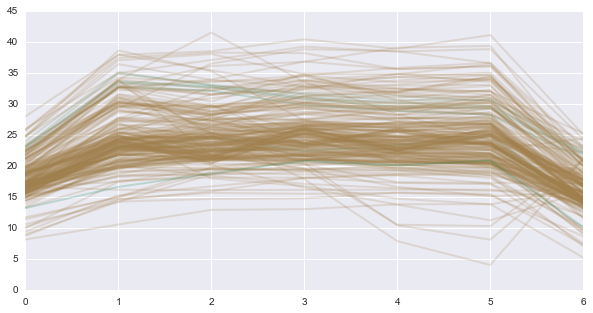

In [366]:
def plot_inf_iteration_loss(X, losses):
    losses = np.array(losses)
    losses = losses/np.max(losses)
#     print(losses)
    n_iterations = len(X[0])
    for i in range(len(X)):# 
        if X[i] != []:
            X_plot = X[i]
            if losses[i] < 0.65:
#             X_plot = X_plot/np.max(X_plot)
                plt.plot(range(n_iterations), X_plot, c =(np.abs(losses[i]),0.5,0.3), linewidth=2.0, alpha=0.2)
  
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "mutual_information(Layersvs.TaskLoss)(not_scaled)")
    plt.savefig(title, format='png', dpi=600)
    plt.show()


        
        
plot_inf_iteration_loss(mut_infs_collect, MIS.losses_task)

In [415]:
entropy_collection

[1.1921958398998163,
 1.6797261887642663,
 1.6300746334530185,
 1.6528437037223711,
 1.6775441392082235,
 1.6858491036127714,
 1.6090863091898047,
 1.5687690108839523,
 1.5091072988368281,
 1.4751077885838615,
 1.4557351554227651,
 1.4382341161921623,
 1.3969214220908044,
 1.3672173487720305,
 1.3270357708726856,
 1.3144872043564022,
 1.3075553122681256,
 1.2629557486788328,
 1.2431738317092462,
 1.2371546861801894,
 1.2244033463076938,
 1.2219736849143785,
 1.2119211019550229,
 1.2073436786630338,
 1.1999992393389098,
 1.1926315719361062,
 1.1977247036880967,
 1.189049034778201,
 1.1910711856880136,
 1.1919165668517553,
 1.1677611408229041,
 1.1650922398922876,
 1.1999783252864031,
 1.1873178359353307,
 1.2103319919243642,
 1.2551337861383824,
 1.2717307619795868,
 1.261998509622752,
 1.2737456081910152,
 1.2515915968415219,
 1.2453032960579944,
 1.2297658871015069,
 1.2249781087747409,
 1.2241208346653933,
 1.2196885235279871,
 1.2092050927101272,
 1.2076814967451379,
 1.199187256776

[0, 556, 1113, 1670, 2165, 2722, 2878, 3435, 3992, 4401, 4958, 5515, 6072, 6629, 7186, 7743, 8300, 8422, 8979, 9536, 10093, 10415, 10972, 11529]


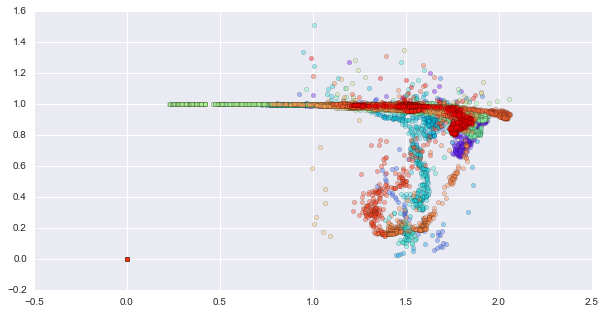

In [426]:
import matplotlib.cm as cm

def plot_entropy_scatter(X, losses):
    ids = [0]
    for i in range(len(losses)):
        if losses[i] == 0.0:
            ids.append(i)
    print(ids)    
    colors = cm.rainbow(np.linspace(0, 1, len(ids)-1))
    for i in range(len(ids)-1):
        x = X[ids[i]:ids[i+1]]
        y = losses[ids[i]:ids[i+1]]
        plt.scatter(x, y, s=20, alpha=0.4, c=colors[i])
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           "mutual_information(Layersvs.TaskLoss)(not_scaled)")
#     plt.savefig(title, format='png', dpi=600)
    
plot_entropy_scatter(entropy_collection, MIS.losses_task)
plt.show()

[0, 556, 1113, 1670]


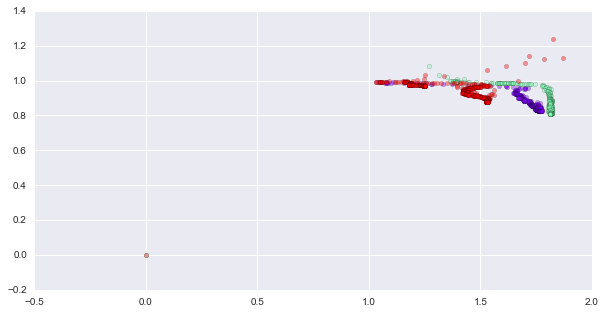

In [429]:
plot_entropy_scatter(entropy_collection1, MIS.losses_task)
plt.show()

# Analyze Losses

In [8]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10,5)

def normalize_epoch_count(a):
    "splits the array into separate sessions and normalizes each session by its maximum id (epoch number)"
    maxs = []
    ids = []
    for i in range(len(a) - 1):
        if a[i+1] < a[i]:
            maxs.append(a[i])
            ids.append(i+1)
    maxs.append(a[-1])
    
    a_split = (np.split(a, ids))
    a_split_norm = [1.0*a_split[i]/maxs[i] for i in range(len(maxs))]
#     print(a_split_norm)
    return np.concatenate(a_split_norm, axis=0), ids

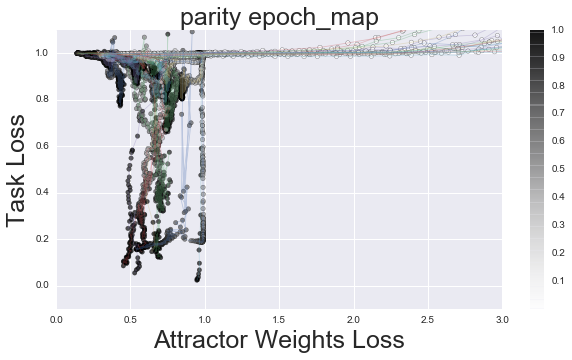

In [420]:
def plot_loss_vs_loss_vs_values(x, y, values, x_label="", y_label="", value_name="", ops=ops, comment=''):
    # Plot...
    plt.scatter(x, y, c=values, s=20, alpha=0.5) # 10*np.arange(1.0, 50.0)
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.title("{}".format(value_name), fontsize=25)
    plt.colorbar()
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           comment)
    
    plt.axis([0, 3, -0.1, 1.1]) 
#     plt.savefig(title, format='png', dpi=600)

def plot_loss_vs_loss_vs_values_lines(x, y, values, ids_split, x_label="", y_label="", value_name="", ops=ops, comment=''):
    # Plot...
    x_list = np.split(x, ids_split)
    y_list = np.split(y, ids_split)
    values_list = np.split(values, ids_split)
    for i in range(len(ids_split) + 1):# 
        x = x_list[i]
        y = y_list[i]
        values = values_list[i]
        plt.scatter(x, y, c=values, s=20, alpha=0.7) # 10*np.arange(1.0, 50.0)
        plt.plot(x, y, linewidth=0.8, alpha=0.3)
        
    plt.xlabel(x_label, fontsize=25)
    plt.ylabel(y_label, fontsize=25)
    plt.title("{}".format(value_name), fontsize=25)
    plt.colorbar()
    title = "experiments/figs/({})[Model<{}>(attractor<{},hid({}),h_hid({}),input_noise({})>, noise<{}>, seq_len<{}>,n_iterations<{}>), Problem<{}>][epochs<{}>, repetitions<{}>]__{}.png".format(datetime.date.today(),
                                                           ops['model_type'], 
                                                           str(ops['attractor_dynamics']),
                                                           ops['hid'],
                                                           ops['h_hid'],
                                                           INPUT_NOISE_LEVEL,
                                                           SEQ_LEN,
                                                           ops['attractor_noise_level'],
                                                           ops['n_attractor_iterations'],
                                                           ops['problem_type'],
                                                           TRAINING_EPOCHS, 
                                                           N_REPLICATIONS,
                                                           ops['attractor_regularization'],
                                                           comment)
    
    plt.axis([0, 3, -0.1, 1.1]) 
#     plt.savefig(title, format='png', dpi=600)


epoch_normalized, ids_split = normalize_epoch_count(WS.epoch_number_history)
plot_loss_vs_loss_vs_values_lines(WS.losses_att, 
                            WS.losses_task,
                            epoch_normalized,
                            ids_split,
                           'Attractor Weights Loss',
                           'Task Loss',
                           ops['problem_type'] + ' epoch_map', 
                           comment = "Test_acc_mean<{:.4f}>".format(np.mean(saved_test_acc)))
# plt.savefig('figs/' + "{}vs{}vs{}__".format(x_label, y_label, value_name) + 
#                "NoiseLambda_{}__Architecture_{}".format(str(ops['attractor_noise_level']), model_type))
plt.show()



In [381]:
import datetime

def save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, comment):
        saved_train_acc = np.array(saved_train_acc)
        saved_test_acc = np.array(saved_test_acc)
        saved_att_loss = np.array(saved_att_loss)
        np.set_printoptions(precision=3)
        results = "\n<RESULTS>:\ntype: \t\t\tmean: \t var: \t\n"
        results += "{} \t{:.4f} \t {:.4f}\n".format("saved_train_acc", np.mean(saved_train_acc), np.var(saved_train_acc))
        results += "{} \t\t{:.4f} \t {:.4f}\n".format("saved_test_acc", np.mean(saved_test_acc), np.var(saved_test_acc))
        results += "{} \t\t{:.4f} \t {:.4f}\n".format("saved_att_loss", np.mean(saved_att_loss), np.var(saved_att_loss))
        
        results += "TRAIN:" + np.array2string(saved_train_acc, formatter={'float_kind':lambda x: "%.3f" % x})
        results += "\nTEST:" + np.array2string(saved_test_acc, formatter={'float_kind':lambda x: "%.3f" % x})
        results += "\nATT_LOSS:" + np.array2string(saved_att_loss, formatter={'float_kind':lambda x: "%.3f" % x})
        #         results += "{} \t {:.4f} \t {:.4f}\n".format("saved_att_loss", np.mean(saved_att_loss), np.var(saved_att_loss))


        title = "experiments/results/{}.txt".format(ops['problem_type']) 
        text = """\n
({}): {}
<NETWORK>:
model_type: \t\t{},
hid: \t\t\t{}, 
h_hid: \t\t\t{}
n_attractor_iterations: {},
attractor_dynamics: \t{}
attractor_noise_level: \t{}
attractor_noise_type: \t{}
attractor_regu-n: \t{}(lambda:{})
TRAIN/TEST_SIZE: \t{}/{}, SEQ_LEN: {}""".format(datetime.date.today(), comment, ops['model_type'], ops['hid'], ops['h_hid'], ops['n_attractor_iterations'], 
                      ops['attractor_dynamics'], ops['attractor_noise_level'], ops['attractor_noise_type'],
                        ops['attractor_regularization'], ops['attractor_regularization_lambda'],
                          N_TRAIN, N_TEST, SEQ_LEN)
           
        text += results
        print(text)
        with open(title, "a") as myfile:
            myfile.write(text)
            print("Saved Results Successfully")
        
comment = ""
save_results(ops, saved_train_acc, saved_test_acc, saved_att_loss, comment)




(2018-03-06): 
<NETWORK>:
model_type: 		GRU,
hid: 			5, 
h_hid: 			5
n_attractor_iterations: 5,
attractor_dynamics: 	projection3
attractor_noise_level: 	0.2
attractor_noise_type: 	bernoilli
attractor_regu-n: 	(lambda:0.05)
TRAIN/TEST_SIZE: 	1000/1000, SEQ_LEN: 12
<RESULTS>:
type: 			mean: 	 var: 	
saved_train_acc 	0.7458 	 0.0286
saved_test_acc 		0.6377 	 0.0339
saved_att_loss 		0.6013 	 0.0245
TRAIN:[0.608 0.792 0.591 1.000 0.601 1.000 0.720 0.974 1.000 0.594 0.637 0.701
 0.627 0.530 0.605 0.646 1.000 0.621 0.950 0.645 1.000 0.601 0.710]
TEST:[0.512 0.627 0.470 0.893 0.545 0.977 0.595 0.712 0.943 0.495 0.489 0.534
 0.507 0.506 0.497 0.540 0.999 0.513 0.865 0.500 0.920 0.517 0.508]
ATT_LOSS:[0.585 0.741 0.481 0.528 0.286 0.946 0.429 0.696 0.452 0.268 0.739 0.726
 0.695 0.619 0.583 0.530 0.643 0.701 0.602 0.667 0.579 0.494 0.840]
Saved Results Successfully


In [33]:
saved_att_loss

[0.27380559]

In [ ]:
saved_train_acc = []
saved_test_acc = []
saved_epoch = []

In [ ]:
get_mean_var(saved_test_acc)

In [ ]:
np.mean(saved_test_acc)
